# 1D Convolution Layer

- Use HOG, Template and the combined HOG and Template Features to train a 1D Convolution Layer classifier


In [1]:
from io import BytesIO
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import polars as pl

try:
    from sklearnex import patch_sklearn
except ImportError:
    %pip install scikit-learn-intelex
    from sklearnex import patch_sklearn
patch_sklearn()

from feature_utils import normalize_histogram
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

from matplotlib.colors import ListedColormap

import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Conv1D, MaxPooling1D, Dropout, BatchNormalization, LeakyReLU, Activation
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.optimizers import Adam, RMSprop

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# split the data into train, validation and test
from sklearn.model_selection import train_test_split

# pause warnings
import warnings
warnings.filterwarnings("ignore")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Read Train and Test Parquet Files that contain all the simple and complex features extracted from the images

- Focus on HOG, Template and the combined features as they are the most important ones from our PCA and TSNE analysis

In [2]:
# Read the parquet file, this takes a while. Leave it here
features_file = Path("data/train_features.parquet")
if not features_file.exists():
    print("No features file found. Please run the create_features_table first")
    exit(1)

meta_file = Path("data/meta_full.parquet")
if not meta_file.exists():
    print("No features file found. Please run the create_features_table first")
    exit(1)

dft = pl.read_parquet(features_file, memory_map=True)
dfm = pl.read_parquet(meta_file, memory_map=True)
dft = dft.join(dfm, on="ClassId")



In [3]:

# Select 200 random samples per class for a total of 8600 samples for model training
samples_per_class = 200
random_seed = 42
pl.set_random_seed(random_seed)
dft = pl.concat(
    [
        x.sample(samples_per_class, with_replacement=False, shuffle=False)
        for x in dft.partition_by("ClassId")
    ]
)
# del dfm

In [4]:
dft.head(1)


id,ClassId,Width,Height,Image,Resolution,Scaled_Meta_Image,Hue_Hist,Saturation_Hist,Value_Hist,LBP_Image,LBP_Hist,HOG_Features,HOG_Image,Template_Pattern,RESNET101,VGG16,Path,ShapeId,ColorId,SignId,Description,Meta_Image,Meta_Width,Meta_Height,Meta_Resolution,Scaled_Meta_Width,Scaled_Meta_Height,Scaled_Meta_Image_right,Scaled_Meta_Resolution
i64,i64,i64,i64,binary,i64,binary,list[i64],list[i64],list[i64],binary,list[i64],list[f32],binary,list[f32],list[f64],list[f64],str,i64,i64,str,str,binary,i64,i64,i64,i64,i64,binary,i64
0,20,64,64,[binary data],4096,[binary data],"[101, 0, … 0]","[10, 0, … 0]","[0, 0, … 0]",[binary data],"[103, 134, … 0]","[0.312697, 0.175225, … 0.0]",[binary data],"[0.305431, 0.296282, … 0.24815]","[0.760675, 0.0, … 0.0]","[0.0, 0.0, … 0.0]","""/work/06333/ed…",0,0,"""1.1""","""Right curve""",[binary data],88,100,8800,64,64,[binary data],4096


In [5]:
dft.shape

(8600, 30)

In [6]:
# dft.columns

In [7]:
# Read the test parquet file, this takes a while. Leave it here

#  For test dataset, we will use all the samples for each class and not just 200 samples per class
#  because we want to test the model on all the samples for each class

features_file_test = Path("data/test_features.parquet")
if not features_file_test.exists():
    print("No features file found. Please run the create_features_table first")
    exit(1)

# meta_file = Path("data/meta_full.parquet")
# if not meta_file.exists():
#     print("No features file found. Please run the create_features_table first")
#     exit(1)

dft_test = pl.read_parquet(features_file_test, memory_map=True)


In [8]:
# # select random samples for test dataset, select 60 samples per class for a total of 2580 samples (the smallest class has ~60 samples)
samples_per_class_test = 60
random_seed = 42
pl.set_random_seed(random_seed)
dft_test_1 = pl.concat(
    [
        x.sample(samples_per_class_test, with_replacement=False, shuffle=False)
        for x in dft_test.partition_by("ClassId")
    ]
)


In [9]:
dft_test_1.shape

(2580, 17)

In [10]:
# Create a training feature file with the following columns:
columns = ['ClassId', 'Hue_Hist', 'Saturation_Hist', 'Value_Hist', 'LBP_Image', 'HOG_Features', 'Template_Pattern']
features = dft[columns]
features.head(1)

ClassId,Hue_Hist,Saturation_Hist,Value_Hist,LBP_Image,HOG_Features,Template_Pattern
i64,list[i64],list[i64],list[i64],binary,list[f32],list[f32]
20,"[101, 0, … 0]","[10, 0, … 0]","[0, 0, … 0]",[binary data],"[0.312697, 0.175225, … 0.0]","[0.305431, 0.296282, … 0.24815]"


In [11]:
# create a test feature file with the following columns:
test = dft_test_1[columns]
test.head(1)

ClassId,Hue_Hist,Saturation_Hist,Value_Hist,LBP_Image,HOG_Features,Template_Pattern
i64,list[i64],list[i64],list[i64],binary,list[f32],list[f32]
16,"[262, 97, … 56]","[171, 166, … 0]","[0, 0, … 459]",[binary data],"[0.177624, 0.062173, … 0.019866]","[0.437069, 0.446226, … 0.356023]"


In [12]:
# get features from each column in the dataframe

def get_lbp_features(df, columns):
    features = []
    numpy_stage1_train = df.with_columns(
        pl.col(columns[0]).map_elements(lambda x: np.load(BytesIO(x))).alias("NumPy")
    )
    X_train_LBP = np.asarray(numpy_stage1_train["NumPy"].to_list())
    del numpy_stage1_train
    X_train_LBP = np.reshape(
        X_train_LBP, (X_train_LBP.shape[0], X_train_LBP.shape[1] * X_train_LBP.shape[2])
    )
    return X_train_LBP


def get_features(df, columns):
    features = []
    for column in columns:
        # if column has more than one value, then vstack the values
        if len(df[column][0]) > 1:
            features.append(np.vstack(df[column]))
        else:
            features.append(df[column])
    # convert features to numpy array
    features = np.hstack(features)
    return features

In [13]:
# get features from each column in the dataframe of the trainining dataset

hue = get_features(dft, ["Hue_Hist"])
saturation = get_features(dft, ["Saturation_Hist"])
lbp = get_lbp_features(dft, ["LBP_Image"])
hog = get_features(dft, ["HOG_Features"])
template = get_features(dft, ["Template_Pattern"])

# combined hog and template features only
features_hog_temp = np.hstack([hog, template])

# combined hue, hog and template features
features_hue_hog_temp = np.hstack([hue, hog, template])

# total features
ttl_features = np.hstack([hue, saturation, lbp, hog, template])

# print the shape of each feature
print("Hue shape: ", hue.shape)
print("Saturation shape: ", saturation.shape)
print("LBP shape: ", lbp.shape)
print("HOG shape: ", hog.shape)
print("Template shape: ", template.shape)
print("HOG + Template shape: ", features_hog_temp.shape)
print("Hue + HOG + Template shape: ", features_hue_hog_temp.shape)
print("Total features: ", ttl_features.shape)


Hue shape:  (8600, 180)
Saturation shape:  (8600, 256)
LBP shape:  (8600, 4096)
HOG shape:  (8600, 2916)
Template shape:  (8600, 3483)
HOG + Template shape:  (8600, 6399)
Hue + HOG + Template shape:  (8600, 6579)
Total features:  (8600, 10931)


In [14]:
# get features from each column in the dataframe

hue_test = get_features(test, ["Hue_Hist"])
saturation_test = get_features(test, ["Saturation_Hist"])
lbp_test = get_lbp_features(test, ["LBP_Image"])
hog_test = get_features(test, ["HOG_Features"])
template_test = get_features(test, ["Template_Pattern"])

# combined hog and template features only
features_hog_temp_test = np.hstack([hog_test, template_test])

# combined hue, hog and template features
features_hue_hog_temp_test = np.hstack([hue_test, hog_test, template_test])

# total features
ttl_features_test = np.hstack([hue_test, saturation_test, lbp_test, hog_test, template_test])

# print the shape of each feature
print("Hue Test shape: ", hue_test.shape)
print("Saturation Test shape: ", saturation_test.shape)
print("LBP Test shape: ", lbp_test.shape)
print("HOG Test shape: ", hog_test.shape)
print("Template Test shape: ", template_test.shape)
print("HOG + Template Test shape: ", features_hog_temp_test.shape)
print("Hue + HOG + Template Test shape: ", features_hue_hog_temp_test.shape)
print("Total Test features: ", ttl_features_test.shape)



Hue Test shape:  (2580, 180)
Saturation Test shape:  (2580, 256)
LBP Test shape:  (2580, 4096)
HOG Test shape:  (2580, 2916)
Template Test shape:  (2580, 3483)
HOG + Template Test shape:  (2580, 6399)
Hue + HOG + Template Test shape:  (2580, 6579)
Total Test features:  (2580, 10931)


In [15]:
# load pca_reduced total features from csv
hog_temp_pca = np.loadtxt(Path("data/features_hog_template_pca.csv"), delimiter=",") 
hog_temp_pca.shape


(8600, 231)

In [16]:
# get class labels
labels = dft["ClassId"].to_numpy()
labels.shape

(8600,)

In [17]:
# get class labels of the test dataset
labels_test = dft_test_1["ClassId"].to_numpy()
labels_test.shape

(2580,)

In [18]:
# split the data into train and validation sets and shuffle the data
from sklearn.preprocessing import StandardScaler

def split_data(features, labels, test_size=0.2, random_state=42):
    # standardize the features
    features = StandardScaler().fit_transform(features)
    # features = features/255.0
    X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=test_size, random_state=random_state)
    return X_train, X_val, y_train, y_val

def split_data_2(features, labels, test_size=0.2, random_state=42):
    # standardize the combined features
    features = features/255.0
    X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=test_size, random_state=random_state)
    return X_train, X_val, y_train, y_val

# split the data into train and validation sets and shuffle the data
X_train_hog, X_val_hog, y_train_hog, y_val_hog = split_data(hog, labels)
X_train_hue, X_val_hue, y_train_hue, y_val_hue = split_data(hue, labels)
X_train_sat, X_val_sat, y_train_sat, y_val_sat = split_data(saturation, labels)
X_train_lbp, X_val_lbp, y_train_lbp, y_val_lbp = split_data(lbp, labels)
X_train_temp, X_val_temp, y_train_temp, y_val_temp = split_data(template, labels)
X_train_hog_temp, X_val_hog_temp, y_train_hog_temp, y_val_hog_temp = split_data(features_hog_temp, labels)
X_train_hue_hog_temp, X_val_hue_hog_temp, y_train_hue_hog_temp, y_val_hue_hog_temp = split_data(features_hue_hog_temp, labels)
X_train_ttl, X_val_ttl, y_train_ttl, y_val_ttl = split_data(ttl_features, labels)
X_train_hog_temp_pca, X_val_hog_temp_pca, y_train_hog_temp_pca, y_val_hog_temp_pca = split_data(hog_temp_pca, labels)

# standardize the test features
X_test_hog = StandardScaler().fit_transform(hog_test)
X_test_hue = StandardScaler().fit_transform(hue_test)
X_test_sat = StandardScaler().fit_transform(saturation_test)
X_test_lbp = StandardScaler().fit_transform(lbp_test)
X_test_temp = StandardScaler().fit_transform(template_test)
X_test_hog_temp = StandardScaler().fit_transform(features_hog_temp_test)
X_test_hue_hog_temp = StandardScaler().fit_transform(features_hue_hog_temp_test)
X_test_ttl = StandardScaler().fit_transform(ttl_features_test)
X_test_hog_temp_pca = StandardScaler().fit_transform(hog_temp_pca)

y_test_hog = labels_test
y_test_hue = labels_test
y_test_sat = labels_test
y_test_lbp = labels_test
y_test_temp = labels_test
y_test_hog_temp = labels_test
y_test_hue_hog_temp = labels_test
y_test_ttl = labels_test
y_test_hog_temp_pca = labels_test





In [19]:
X_train_hog_temp_2, X_val_hog_temp_2, y_train_hog_temp_2, y_val_hog_temp_2 = split_data_2(features_hog_temp, labels)
X_test_hog_temp_2 = StandardScaler().fit_transform(features_hog_temp_test)

# min and max values of the training dataset
print("HOG temp min: ", np.min(X_train_hog_temp_2), "HOG max: ", np.max(X_train_hog_temp_2))
print("Hog temp orginal min: ", np.min(features_hog_temp), "Hog original max: ", np.max(features_hog_temp))
print("Hog tesmp test min: ", np.min(X_test_hog_temp_2), "Hog test max: ", np.max(X_test_hog_temp_2))

HOG temp min:  -0.0032123327 HOG max:  0.003921569
Hog temp orginal min:  -0.81914485 Hog original max:  1.0
Hog tesmp test min:  -5.3346243 Hog test max:  9.678303


In [20]:
# check min and max values of the features
print("template: ", template.min(), template.max())
print("template scaled: ", X_train_temp.min(), X_train_temp.max())
print("template_test: ", template_test.min(), template_test.max())
print("template_test scaled: ", X_test_temp.min(), X_test_temp.max())
print("hog: ", hog.min(), hog.max())
print("hog scaled: ", X_train_hog.min(), X_train_hog.max())
print("hog_temp: ", features_hog_temp.min(), features_hog_temp.max())
print("hog_temp scaled: ", X_train_hog_temp.min(), X_train_hog_temp.max())
print("hog_temp_test: ", features_hog_temp_test.min(), features_hog_temp_test.max())
print("hog_temp_test scaled: ", X_test_hog_temp.min(), X_test_hog_temp.max())






template:  -0.81914485 0.8547862
template scaled:  -5.336125 6.1441884
template_test:  -0.861136 0.856697
template_test scaled:  -5.3346243 5.2185564
hog:  0.0 1.0
hog scaled:  -2.5067937 13.343373
hog_temp:  -0.81914485 1.0
hog_temp scaled:  -5.336125 13.343373
hog_temp_test:  -0.861136 1.0
hog_temp_test scaled:  -5.3346243 9.678303


In [21]:
print(X_train_hog.shape)
print(y_train_hog.shape)
print(X_train_hog_temp_pca.shape)
print(y_train_hog_temp_pca.shape)
print(X_test_hog.shape)
print(y_test_hog.shape)

(6880, 2916)
(6880,)
(6880, 231)
(6880,)
(2580, 2916)
(2580,)


In [22]:
# get the input shape
ms_input_shape_hue = (X_train_hue.shape[1], 1)
ms_input_shape_sat = (X_train_sat.shape[1], 1)
ms_input_shape_lbp = (X_train_lbp.shape[1], 1)
ms_input_shape_hog = (X_train_hog.shape[1], 1)
ms_input_shape_temp = (X_train_temp.shape[1], 1)
ms_input_shape_hog_temp = (X_train_hog_temp.shape[1], 1)
ms_input_shape_hue_hog_temp = (X_train_hue_hog_temp.shape[1], 1)
ms_input_shape_ttl = (X_train_ttl.shape[1], 1)
ms_input_shape_hog_temp_pca = (X_train_hog_temp_pca.shape[1], 1)


### 1D Convolution Model

In [23]:
# define 1D CONV model
def create_cnn_model(padding='same',               
                    input_shape= ms_input_shape_hog,
                    learn_rate=0.001):
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    model = Sequential()
    model.add(Conv1D(filters=6, kernel_size=21, strides=1, padding=padding, activation='relu', 
                    input_shape= input_shape,kernel_initializer=keras.initializers.he_normal()))
    model.add(BatchNormalization()) 
    model.add(MaxPooling1D(pool_size=2, strides=2, padding=padding))
    model.add(Conv1D(filters=16, kernel_size=5, strides=1, padding=padding,activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2, strides=2, padding=padding))
    model.add(Flatten())
    model.add(Dense(120, activation='relu'))
    model.add(Dense(84))
    model.add(Dropout(rate=0.5, name='Dropout'))
    model.add(Dense(43, activation='softmax', name='Output'))
    model.compile(optimizer=Adam(learning_rate=learn_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

###########################################################################################################
# create model using the hog features and print the summary

###########################################################################################################
model_hog = create_cnn_model(input_shape=ms_input_shape_hog)
model_hog.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2916, 6)           132       
                                                                 
 batch_normalization (Batch  (None, 2916, 6)           24        
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 1458, 6)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 1458, 16)          496       
                                                                 
 batch_normalization_1 (Bat  (None, 1458, 16)          64        
 chNormalization)                                                
                                                        

In [24]:
# create model using the other individual features and total features
model_hue = create_cnn_model(input_shape=ms_input_shape_hue)
model_sat = create_cnn_model(input_shape=ms_input_shape_sat)
model_lbp = create_cnn_model(input_shape=ms_input_shape_lbp)
model_temp = create_cnn_model(input_shape=ms_input_shape_temp)
model_hog_temp = create_cnn_model(input_shape=ms_input_shape_hog_temp)
model_hog_temp_pca = create_cnn_model(input_shape=ms_input_shape_hog_temp_pca)
model_hue_hog_temp = create_cnn_model(input_shape=ms_input_shape_hue_hog_temp)
model_ttl = create_cnn_model(input_shape=ms_input_shape_ttl)


In [25]:
# create a callback list including early stopping and model checkpoint

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)   ]


##### Train a model using the hog features

In [26]:
BATCH_SIZE = 32 
EPOCHS = 10

history_hog = model_hog.fit(X_train_hog,
                    y_train_hog,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    validation_data=(X_val_hog, y_val_hog), 
                    # validation_split=0.2,        
                    verbose=1)

Epoch 1/10
215/215 [==============================] - 17s 63ms/step - loss: 1.4326 - accuracy: 0.6289 - val_loss: 0.3001 - val_accuracy: 0.9174
Epoch 2/10
215/215 [==============================] - 15s 68ms/step - loss: 0.3037 - accuracy: 0.9141 - val_loss: 0.2382 - val_accuracy: 0.9256
Epoch 3/10
215/215 [==============================] - 15s 69ms/step - loss: 0.1540 - accuracy: 0.9584 - val_loss: 0.2884 - val_accuracy: 0.9395
Epoch 4/10
215/215 [==============================] - 14s 63ms/step - loss: 0.0878 - accuracy: 0.9746 - val_loss: 0.2594 - val_accuracy: 0.9337
Epoch 5/10
215/215 [==============================] - 13s 63ms/step - loss: 0.0634 - accuracy: 0.9836 - val_loss: 0.2169 - val_accuracy: 0.9500
Epoch 6/10
215/215 [==============================] - 12s 58ms/step - loss: 0.0484 - accuracy: 0.9876 - val_loss: 0.2653 - val_accuracy: 0.9459
Epoch 7/10
215/215 [==============================] - 13s 59ms/step - loss: 0.0404 - accuracy: 0.9887 - val_loss: 0.2771 - val_accuracy:

In [27]:
# The laste training and validation accuracy
print("The last training accuracy: ", history_hog.history['accuracy'][-1])
print("The last validation accuracy: ", history_hog.history['val_accuracy'][-1])

The last training accuracy:  0.9867732524871826
The last validation accuracy:  0.9412790536880493


In [28]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results_hog = model_hog.evaluate(X_test_hog, y_test_hog, batch_size=32)
# display the results in percentage and 2 decimal points
results_hog = [round(x,4) for x in results_hog]
print("test loss, test acc:", results_hog)


Evaluate on test data
81/81 [==============================] - 1s 12ms/step - loss: 0.5867 - accuracy: 0.8764
test loss, test acc: [0.5867, 0.8764]


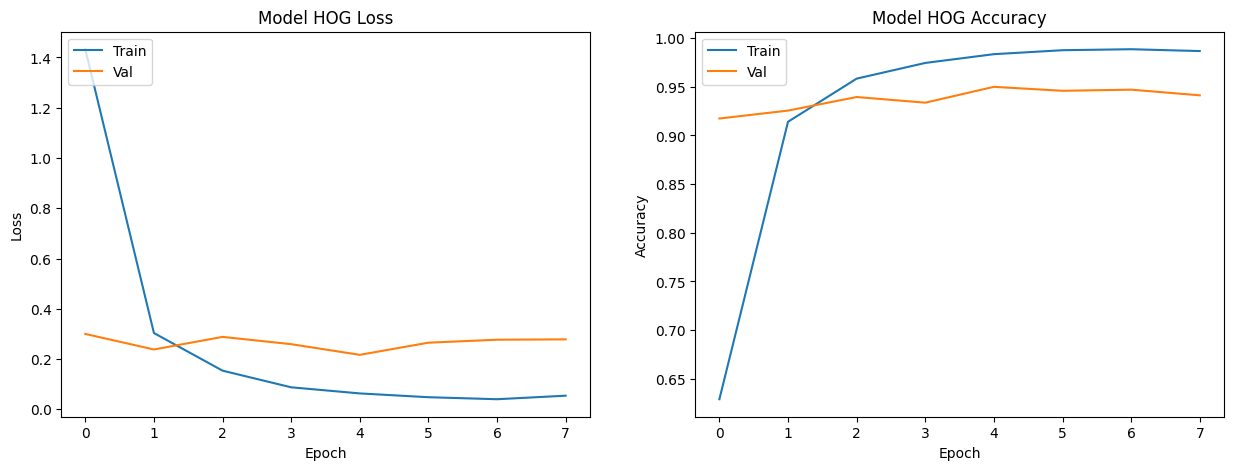

In [29]:
# define a function to plot the accuracy and loss for the model

def plot_accuracy_loss(history, name= "Model HOG"):

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title(name + ' Loss')
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Val'], loc='upper left')

    axs[1].plot(history.history['accuracy'])
    axs[1].plot(history.history['val_accuracy'])
    axs[1].set_title(name + ' Accuracy')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Val'], loc='upper left')

    plt.show()

plot_accuracy_loss(history_hog)


In [30]:
# Create a confusion matrix as a 2D array.
def plot_confusion_matrix(title, y_test, y_prediction):
    label_names = [f"Class {i}" for i in range(43)]

    confusion_matrix = tf.math.confusion_matrix(y_test, y_prediction)
    plt.figure(figsize=(12, 10))

    color_map1 = ['lightgrey', '#ffff99', 'orange', '#7fc97f']
    color_map = ListedColormap(color_map1)

    sns.heatmap(
        confusion_matrix,
        annot=True,
        fmt="d",
        cmap=color_map,
        linewidths=0.5,
        square=True,
        cbar_kws={"label": "Count"},
        xticklabels=label_names,
        yticklabels=label_names,
        annot_kws={"size": 10},
    )
    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("Actual", fontsize=12)
    plt.title(title + " Confusion Matrix", fontsize=14)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=80, ha="right", fontsize=10)
    plt.yticks(rotation=0, fontsize=10)

    # Adjust layout to prevent cutoff of labels
    plt.tight_layout()

    # Add axis labels.
    # ax.set(xlabel="Predicted Label", ylabel="True Label")
    plt.show()
    return

Predicting ...
 1/54 [..............................] - ETA: 2s

54/54 [==============================] - 1s 11ms/step

Accuracy on Validation Set: 94.12790697674419


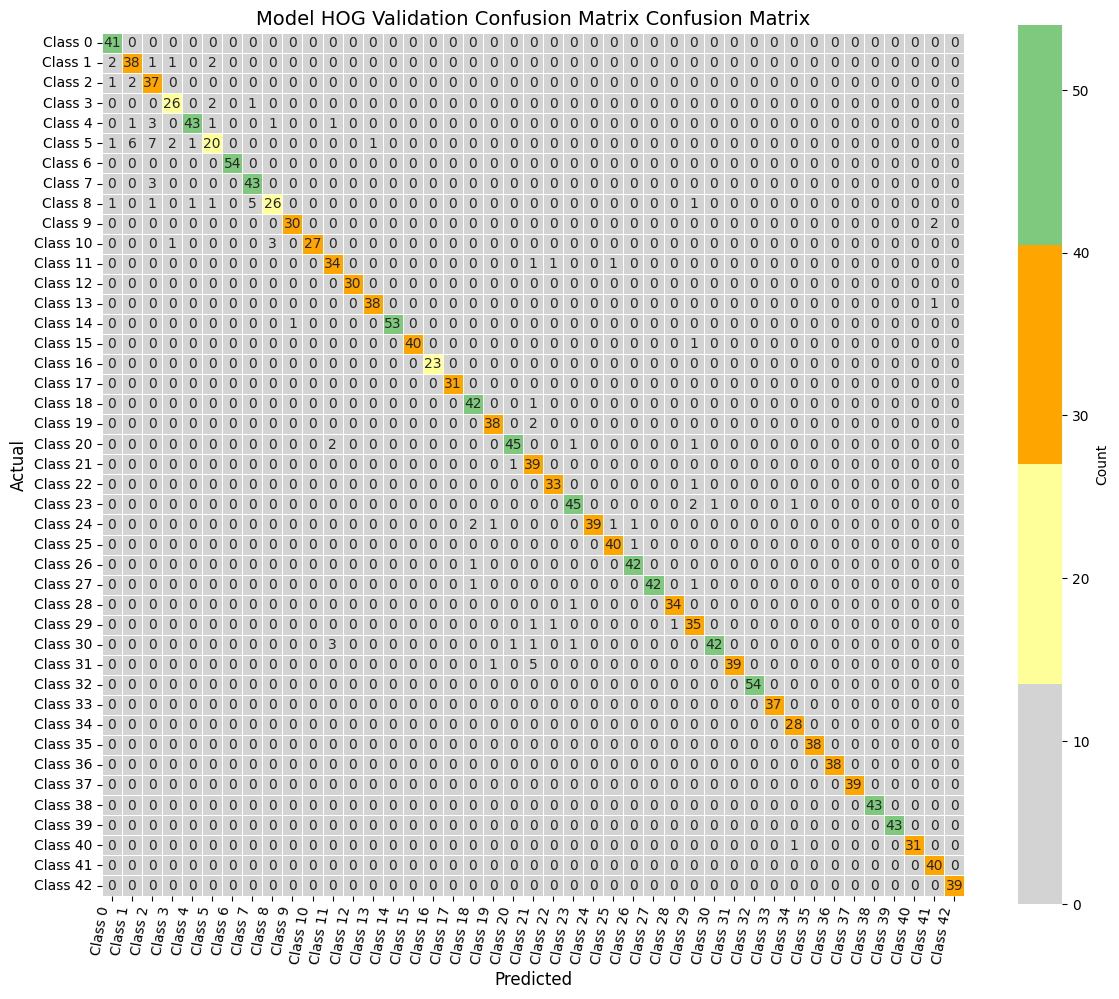

In [55]:
# comfusion matrix

# Predict
print('Predicting ...')
y_pred_hog_val = model_hog.predict(X_val_hog)

y_prediction_hog_val = np.full(shape=(y_pred_hog_val.shape[0]), fill_value=-1)
row = 0
for p in y_pred_hog_val:
    clase = np.argmax(p)
    y_prediction_hog_val[row] = clase
    row+=1

accuracy_hog_val = accuracy_score(y_val_hog, y_prediction_hog_val)
print("\nAccuracy on Validation Set:", accuracy_hog_val*100)

plot_confusion_matrix('Model HOG Validation Confusion Matrix', y_val_hog, y_prediction_hog_val)


Predicting ...
 1/81 [..............................] - ETA: 2s

81/81 [==============================] - 1s 10ms/step

Accuracy on Test Set: 87.63565891472868


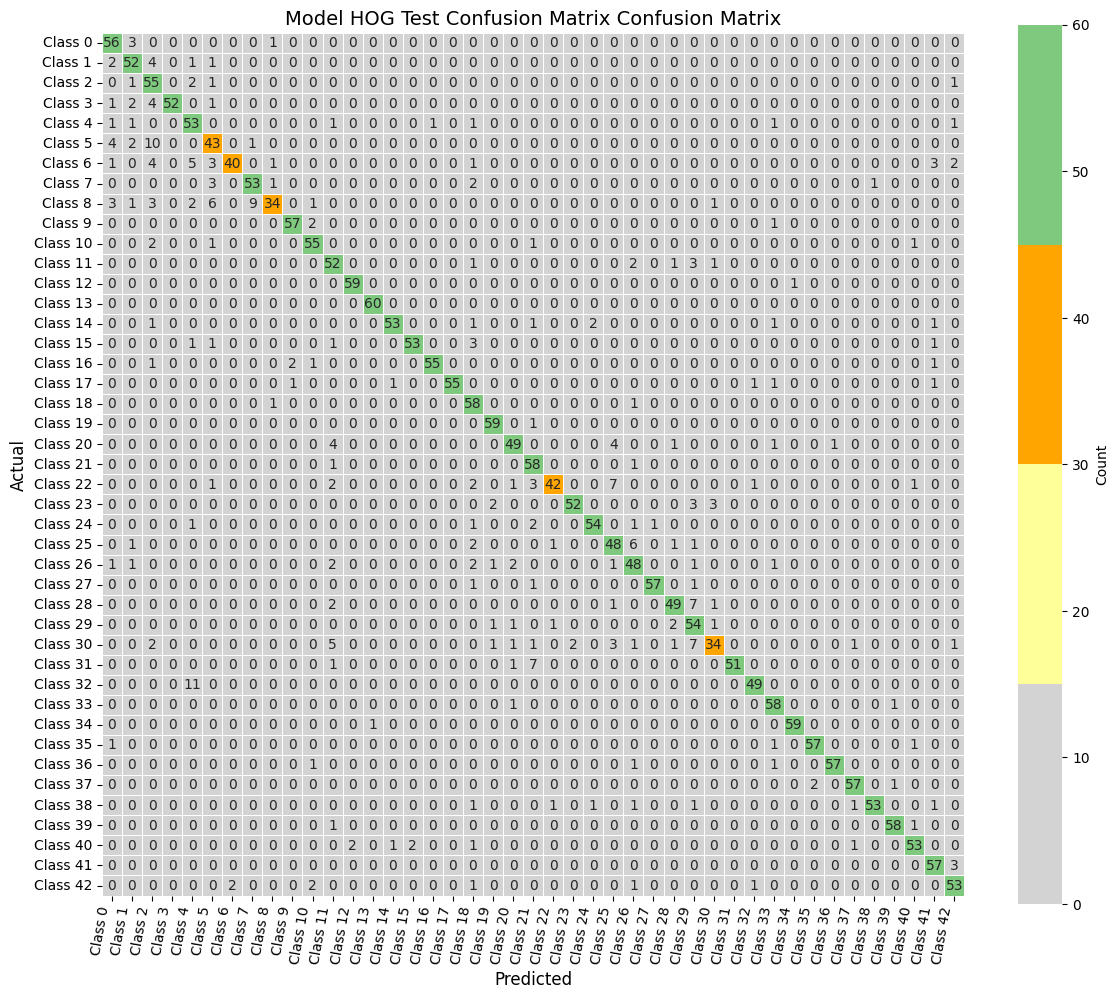

In [51]:
# comfusion matrix

# Predict
print('Predicting ...')
y_pred = model_hog.predict(X_test_hog)

y_prediction = np.full(shape=(y_pred.shape[0]), fill_value=-1)
row = 0
for p in y_pred:
    clase = np.argmax(p)
    y_prediction[row] = clase
    row+=1

accuracy = accuracy_score(y_test_hog, y_prediction)
print("\nAccuracy on Test Set:", accuracy*100)

plot_confusion_matrix('Model HOG Test Confusion Matrix', y_test_hog, y_prediction)


In [32]:
# show the classification report
print("Classification Report")
print(classification_report(y_test_hog, y_prediction))



Classification Report
              precision    recall  f1-score   support

           0       0.80      0.93      0.86        60
           1       0.81      0.87      0.84        60
           2       0.64      0.92      0.75        60
           3       1.00      0.87      0.93        60
           4       0.70      0.88      0.78        60
           5       0.70      0.72      0.71        60
           6       0.95      0.67      0.78        60
           7       0.84      0.88      0.86        60
           8       0.89      0.57      0.69        60
           9       0.95      0.95      0.95        60
          10       0.89      0.92      0.90        60
          11       0.72      0.87      0.79        60
          12       0.97      0.98      0.98        60
          13       0.98      1.00      0.99        60
          14       0.96      0.88      0.92        60
          15       0.96      0.88      0.92        60
          16       0.98      0.92      0.95        60
     

In [33]:
# get the indices of misclassified images of class 26
misclassified_idx_26 = np.where((y_test_hog != y_prediction) & (y_test_hog == 26))[0]
print("Number of misclassified images of class 26: ", len(misclassified_idx_26))



Number of misclassified images of class 26:  12


##### Train a model using the Template features

Epoch 1/10
215/215 [==============================] - 15s 63ms/step - loss: 3.8698 - accuracy: 0.2549 - val_loss: 1.7548 - val_accuracy: 0.5715
Epoch 2/10
215/215 [==============================] - 14s 63ms/step - loss: 1.7765 - accuracy: 0.5488 - val_loss: 1.2179 - val_accuracy: 0.6791
Epoch 3/10
215/215 [==============================] - 13s 63ms/step - loss: 1.3179 - accuracy: 0.6561 - val_loss: 0.9994 - val_accuracy: 0.7407
Epoch 4/10
215/215 [==============================] - 13s 62ms/step - loss: 0.9953 - accuracy: 0.7420 - val_loss: 0.8071 - val_accuracy: 0.7872
Epoch 5/10
215/215 [==============================] - 14s 64ms/step - loss: 0.8131 - accuracy: 0.7887 - val_loss: 0.7039 - val_accuracy: 0.8157
Epoch 6/10
215/215 [==============================] - 14s 63ms/step - loss: 0.6876 - accuracy: 0.8212 - val_loss: 0.7203 - val_accuracy: 0.8157
Epoch 7/10
215/215 [==============================] - 14s 65ms/step - loss: 0.5445 - accuracy: 0.8576 - val_loss: 0.7443 - val_accuracy:

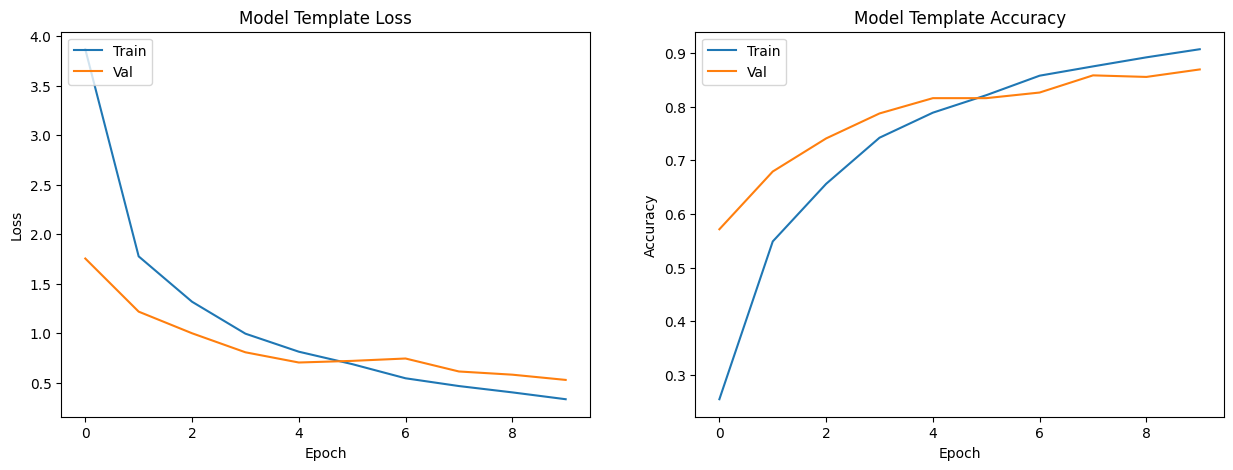

In [34]:
# train model to use the template features
history_temp = model_temp.fit(X_train_temp,
                    y_train_temp,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    # use X_val and y_val for validation data

                    validation_data=(X_val_temp, y_val_temp),

                    validation_split=0.2,
                    verbose=1)

plot_accuracy_loss(history_temp, "Model Template")

In [35]:
# The laste training and validation accuracy
print("The last training accuracy: ", history_temp.history['accuracy'][-1])
print("The last validation accuracy: ", history_temp.history['val_accuracy'][-1])

The last training accuracy:  0.9068313837051392
The last validation accuracy:  0.8691860437393188


In [36]:
# evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results_temp = model_temp.evaluate(X_test_temp, y_test_temp, batch_size=32)
# display the results in percentage and 2 decimal points
results_temp = [round(x,4) for x in results_temp]
print("test loss, test acc:", results_temp)


Evaluate on test data
81/81 [==============================] - 1s 13ms/step - loss: 1.5751 - accuracy: 0.7260
test loss, test acc: [1.5751, 0.726]


Predicting ...
54/54 [==============================] - 1s 11ms/step

Accuracy on Validation Set: 86.9186046511628


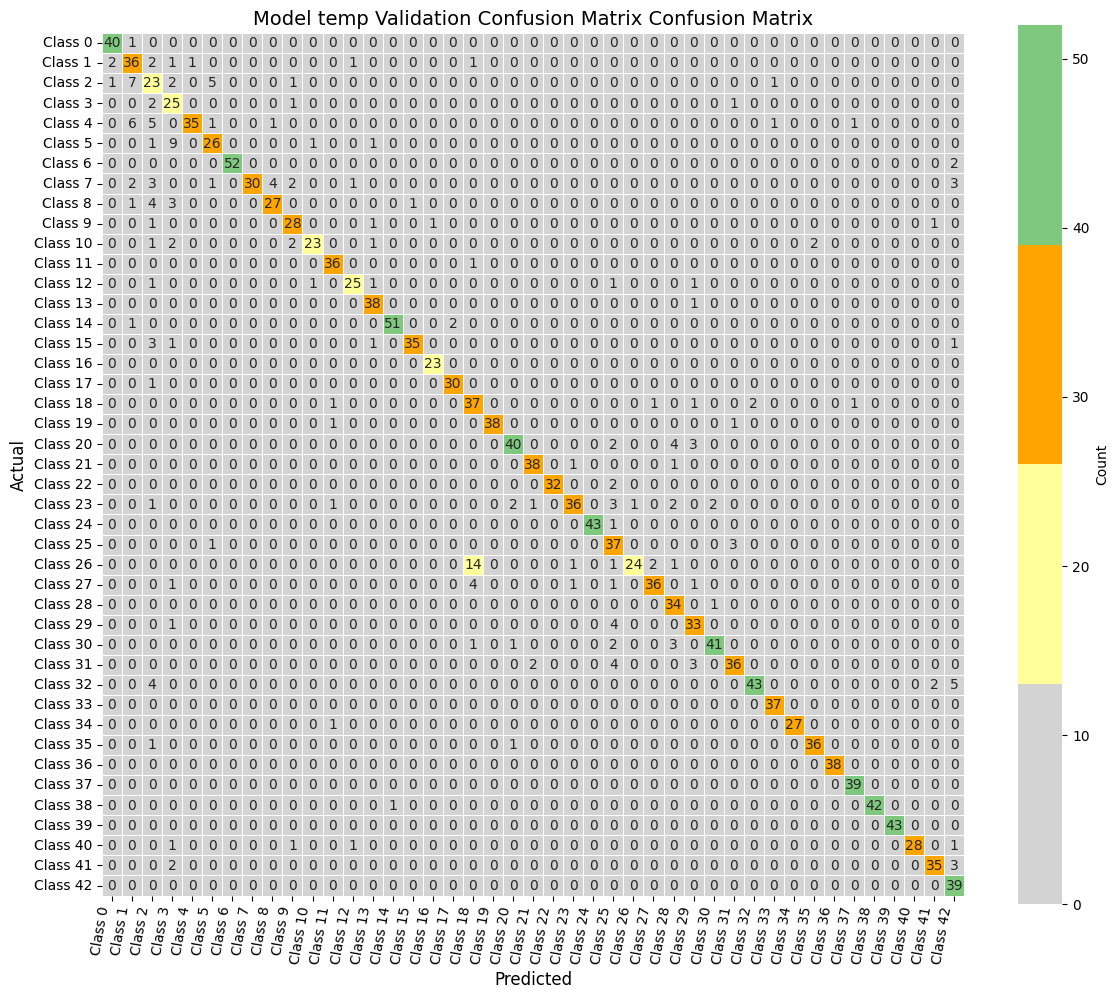

In [54]:
# comfusion matrix

# Predict
print('Predicting ...')
y_pred_temp_val = model_temp.predict(X_val_temp)

y_prediction_temp_val = np.full(shape=(y_pred_temp_val.shape[0]), fill_value=-1)
row = 0
for p in y_pred_temp_val:
    clase = np.argmax(p)
    y_prediction_temp_val[row] = clase
    row+=1

accuracy_temp_val = accuracy_score(y_val_temp, y_prediction_temp_val)
print("\nAccuracy on Validation Set:", accuracy_temp_val*100)

plot_confusion_matrix('Model temp Validation Confusion Matrix', y_val_temp, y_prediction_temp_val)


Predicting ...
 1/81 [..............................] - ETA: 2s

81/81 [==============================] - 1s 11ms/step

Accuracy on Test Set: 72.5968992248062


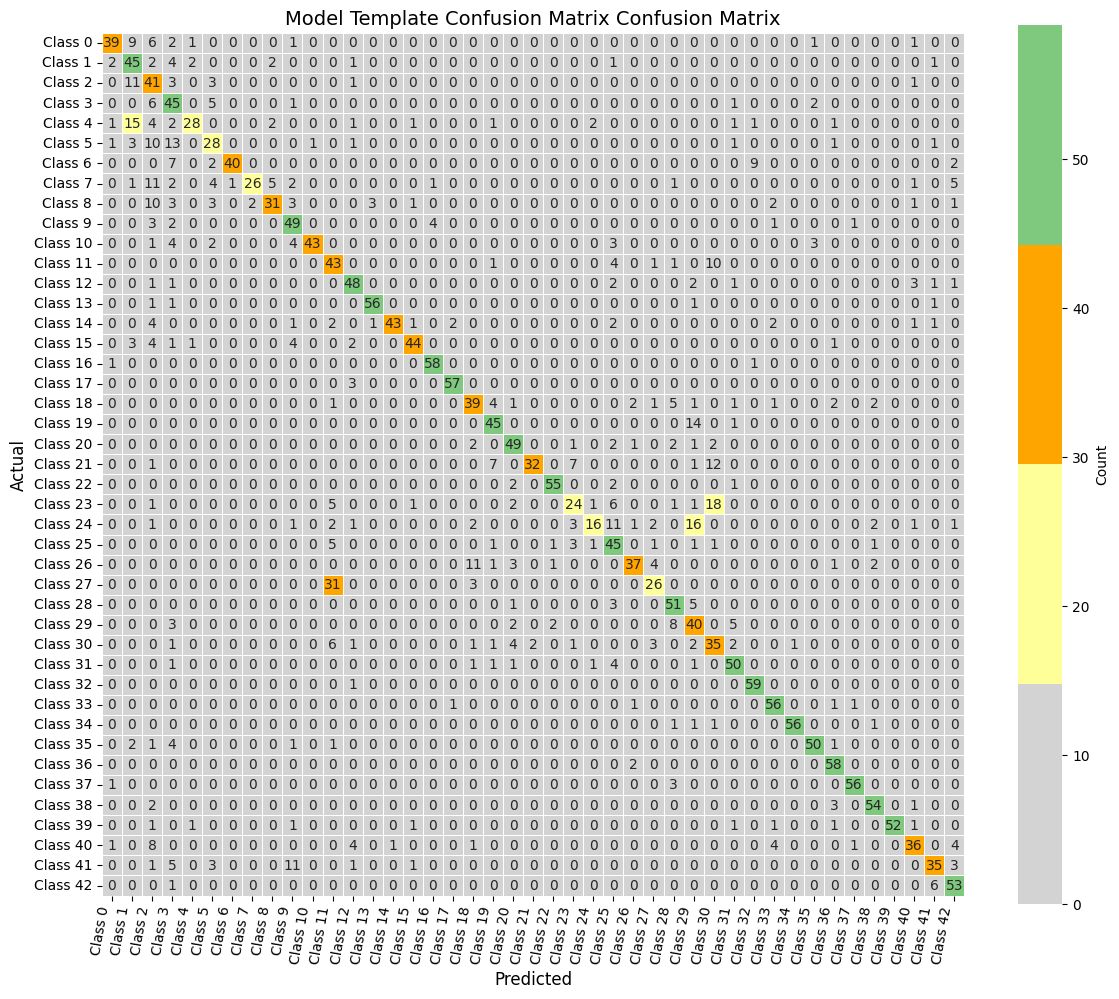

In [47]:
# comfusion matrix

# Predict
print('Predicting ...')
y_pred_temp = model_temp.predict(X_test_temp)

y_prediction_temp = np.full(shape=(y_pred_temp.shape[0]), fill_value=-1)
row = 0
for p in y_pred_temp:
    clase = np.argmax(p)
    y_prediction_temp[row] = clase
    row+=1

accuracy_temp = accuracy_score(y_test_temp, y_prediction_temp)
print("\nAccuracy on Test Set:", accuracy_temp*100)

plot_confusion_matrix('Model Template Confusion Matrix', y_test_temp, y_prediction_temp)

In [38]:
# show the classification report
print("Classification Report")
print(classification_report(y_test_temp, y_prediction_temp))

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.65      0.74        60
           1       0.51      0.75      0.60        60
           2       0.34      0.68      0.46        60
           3       0.43      0.75      0.55        60
           4       0.85      0.47      0.60        60
           5       0.56      0.47      0.51        60
           6       0.98      0.67      0.79        60
           7       0.93      0.43      0.59        60
           8       0.78      0.52      0.62        60
           9       0.62      0.82      0.71        60
          10       0.98      0.72      0.83        60
          11       0.45      0.72      0.55        60
          12       0.74      0.80      0.77        60
          13       0.93      0.93      0.93        60
          14       0.98      0.72      0.83        60
          15       0.88      0.73      0.80        60
          16       0.92      0.97      0.94        60
     

### Trade a Hue model

Epoch 1/10
215/215 [==============================] - 4s 10ms/step - loss: 3.3801 - accuracy: 0.1400 - val_loss: 2.8150 - val_accuracy: 0.2552
Epoch 2/10
215/215 [==============================] - 2s 9ms/step - loss: 2.6333 - accuracy: 0.2576 - val_loss: 2.3514 - val_accuracy: 0.3471
Epoch 3/10
215/215 [==============================] - 2s 9ms/step - loss: 2.2707 - accuracy: 0.3533 - val_loss: 2.1119 - val_accuracy: 0.3965
Epoch 4/10
215/215 [==============================] - 2s 9ms/step - loss: 1.9907 - accuracy: 0.4214 - val_loss: 2.0460 - val_accuracy: 0.4238
Epoch 5/10
215/215 [==============================] - 2s 9ms/step - loss: 1.7443 - accuracy: 0.4879 - val_loss: 1.9373 - val_accuracy: 0.4459
Epoch 6/10
215/215 [==============================] - 2s 9ms/step - loss: 1.5445 - accuracy: 0.5424 - val_loss: 1.9206 - val_accuracy: 0.4564
Epoch 7/10
215/215 [==============================] - 2s 9ms/step - loss: 1.3486 - accuracy: 0.5938 - val_loss: 1.9188 - val_accuracy: 0.4698
Epoch

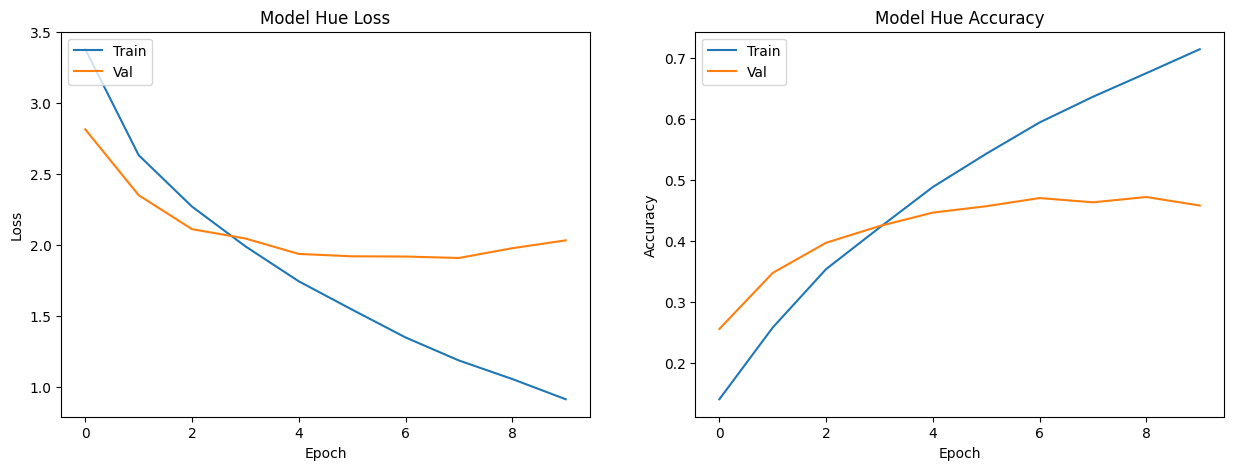

In [39]:
BATCH_SIZE = 32
EPOCHS = 10
# train model to use the template features
history_hue = model_hue.fit(X_train_hue,
                    y_train_hue,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    # use X_val and y_val for validation data
                    validation_data=(X_val_hue, y_val_hue),
                    verbose=1)

plot_accuracy_loss(history_hue, "Model Hue")

##### Train a model using the hue features

In [40]:
# evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results_hue = model_hue.evaluate(X_test_hue, y_test_hue, batch_size=32)
# display the results in percentage and 2 decimal points
results_hue = [round(x,4) for x in results_hue]
print("test loss, test acc:", results_hue)

Evaluate on test data
81/81 [==============================] - 0s 4ms/step - loss: 4.2741 - accuracy: 0.1628
test loss, test acc: [4.2741, 0.1628]


Predicting ...
 1/81 [..............................] - ETA: 1s

81/81 [==============================] - 0s 3ms/step

Accuracy on Test Set: 16.27906976744186


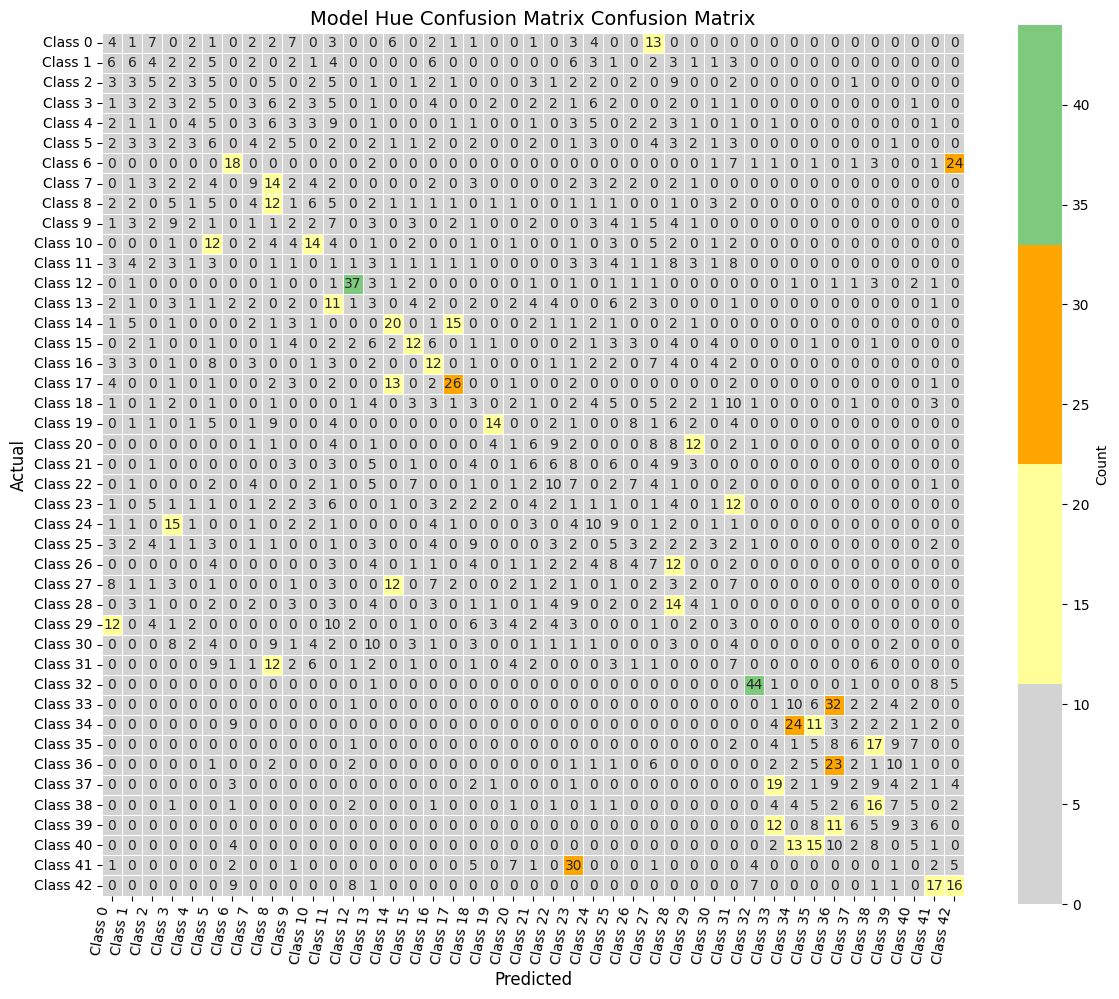

In [48]:
# comfusion matrix

# Predict
print('Predicting ...')
y_pred_hue = model_hue.predict(X_test_hue)

y_prediction_hue = np.full(shape=(y_pred_hue.shape[0]), fill_value=-1)
row = 0
for p in y_pred_hue:
    clase = np.argmax(p)
    y_prediction_hue[row] = clase
    row+=1

accuracy_hue = accuracy_score(y_test_hue, y_prediction_hue)
print("\nAccuracy on Test Set:", accuracy_hue*100)

plot_confusion_matrix('Model Hue Confusion Matrix', y_test_hue, y_prediction_hue)

In [43]:
# show the classification report
print("Classification Report")
print(classification_report(y_test_hue, y_prediction_hue))

Classification Report
              precision    recall  f1-score   support

           0       0.07      0.07      0.07        60
           1       0.12      0.10      0.11        60
           2       0.10      0.08      0.09        60
           3       0.04      0.05      0.05        60
           4       0.13      0.07      0.09        60
           5       0.06      0.10      0.08        60
           6       0.37      0.30      0.33        60
           7       0.18      0.15      0.17        60
           8       0.13      0.20      0.15        60
           9       0.04      0.03      0.03        60
          10       0.26      0.23      0.25        60
          11       0.01      0.02      0.01        60
          12       0.63      0.62      0.62        60
          13       0.04      0.05      0.05        60
          14       0.34      0.33      0.34        60
          15       0.27      0.20      0.23        60
          16       0.17      0.20      0.18        60
     

#### Train a LBP model

In [44]:
# train model to use the LBP features
history_lbp = model_lbp.fit(X_train_lbp,
                    y_train_lbp,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    # use X_val and y_val for validation data
                    validation_data=(X_val_lbp, y_val_lbp),
                    verbose=0)

In [45]:
# The laste training and validation accuracy
print("The last training accuracy: ", history_lbp.history['accuracy'][-1])
print("The last validation accuracy: ", history_lbp.history['val_accuracy'][-1])

# evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results_lbp = model_lbp.evaluate(X_test_lbp, y_test_lbp, batch_size=32)
# display the results in percentage and 2 decimal points
results_lbp = [round(x,4) for x in results_lbp]
print("test loss, test acc:", results_lbp)

The last training accuracy:  0.9797965288162231
The last validation accuracy:  0.8872092962265015
Evaluate on test data
81/81 [==============================] - 1s 13ms/step - loss: 0.9920 - accuracy: 0.8008
test loss, test acc: [0.992, 0.8008]


Predicting ...
54/54 [==============================] - 1s 12ms/step

Accuracy on Validation Set: 88.72093023255813


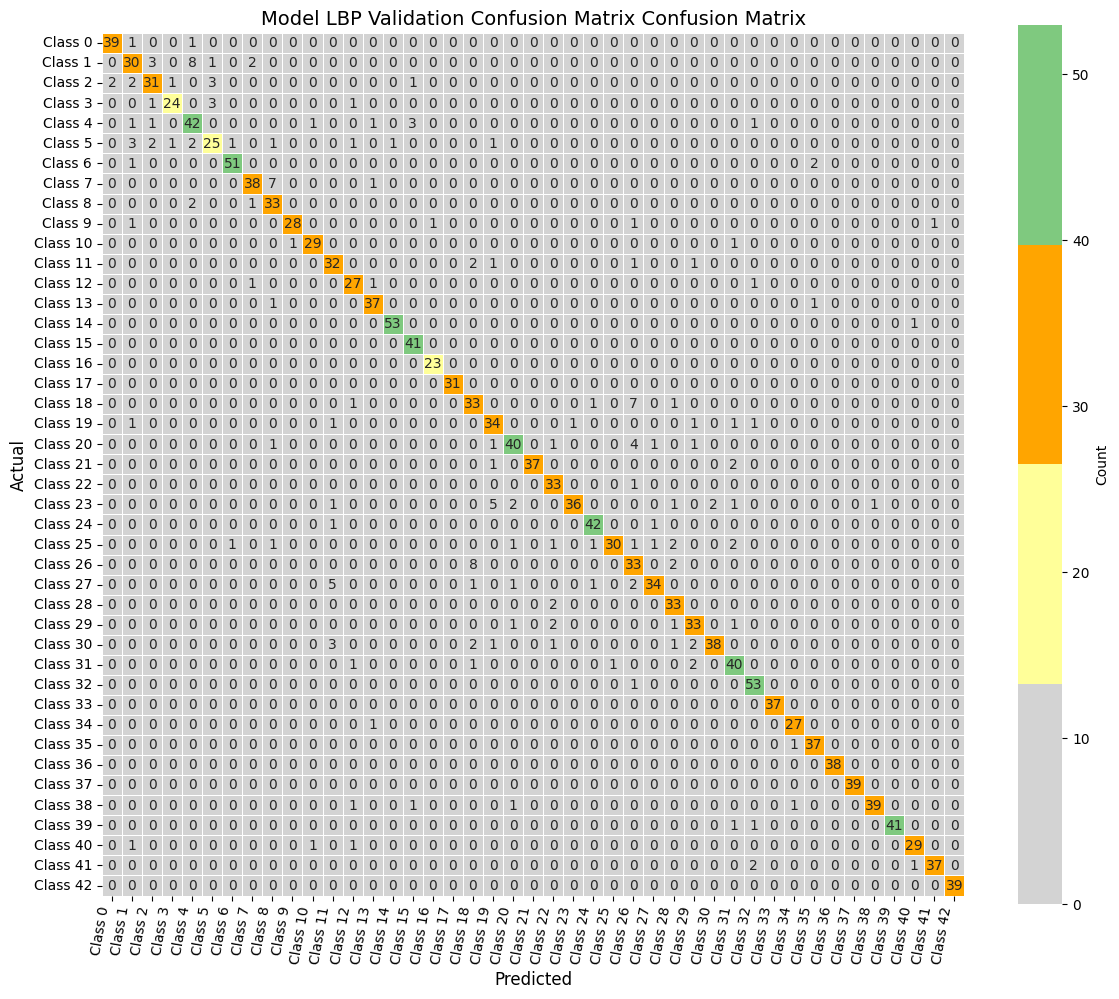

In [58]:
# comfusion matrix

# Predict
print('Predicting ...')
y_pred_lbp_val = model_lbp.predict(X_val_lbp)

y_prediction_lbp_val = np.full(shape=(y_pred_lbp_val.shape[0]), fill_value=-1)
row = 0
for p in y_pred_lbp_val:
    clase = np.argmax(p)
    y_prediction_lbp_val[row] = clase
    row+=1

accuracy_lbp_val = accuracy_score(y_val_lbp, y_prediction_lbp_val)
print("\nAccuracy on Validation Set:", accuracy_lbp_val*100)

plot_confusion_matrix('Model LBP Validation Confusion Matrix', y_val_lbp, y_prediction_lbp_val)

Predicting ...
81/81 [==============================] - 1s 13ms/step

Accuracy on Test Set: 80.07751937984496


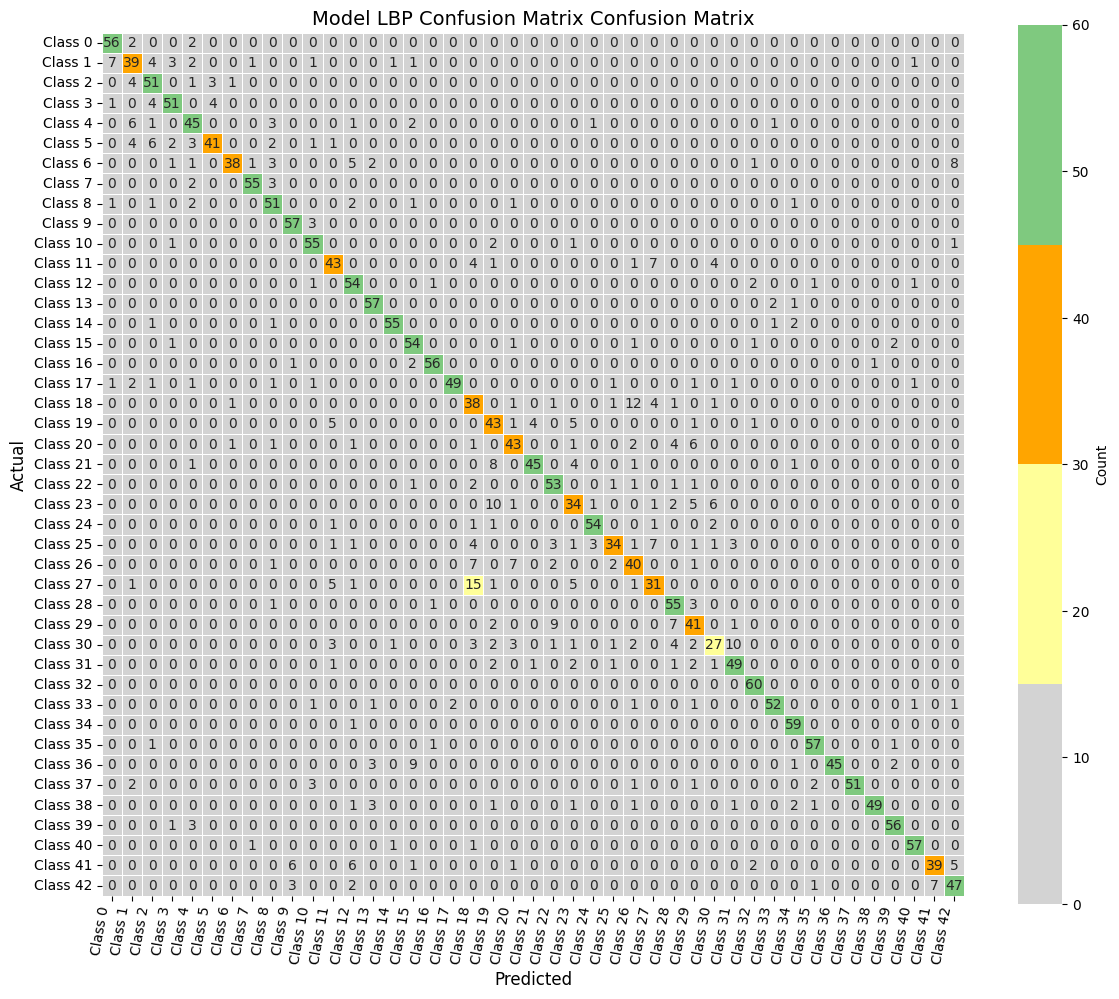

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.93      0.89        60
           1       0.65      0.65      0.65        60
           2       0.73      0.85      0.78        60
           3       0.85      0.85      0.85        60
           4       0.71      0.75      0.73        60
           5       0.85      0.68      0.76        60
           6       0.93      0.63      0.75        60
           7       0.95      0.92      0.93        60
           8       0.76      0.85      0.80        60
           9       0.85      0.95      0.90        60
          10       0.83      0.92      0.87        60
          11       0.72      0.72      0.72        60
          12       0.72      0.90      0.80        60
          13       0.86      0.95      0.90        60
          14       0.95      0.92      0.93        60
          15       0.76      0.90      0.82        60
          16       0.95      0.93      0.94        60
     

In [49]:
# comfusion matrix

# Predict
print('Predicting ...')
y_pred_lbp = model_lbp.predict(X_test_lbp)

y_prediction_lbp = np.full(shape=(y_pred_lbp.shape[0]), fill_value=-1)
row = 0
for p in y_pred_lbp:
    clase = np.argmax(p)
    y_prediction_lbp[row] = clase
    row+=1

accuracy_lbp = accuracy_score(y_test_lbp, y_prediction_lbp)
print("\nAccuracy on Test Set:", accuracy_lbp*100)

plot_confusion_matrix('Model LBP Confusion Matrix', y_test_lbp, y_prediction_lbp)

# show the classification report
print("Classification Report")
print(classification_report(y_test_lbp, y_prediction_lbp))



##### Train a model using the hog + template features

In [ ]:
# train a model for hog and template features
EPOCHS = 10

history_hog_temp = model_hog_temp.fit(X_train_hog_temp,
                    y_train_hog_temp,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    validation_data=(X_val_hog_temp, y_val_hog_temp),
                    # validation_split=0.2,
                    verbose=1)

plot_accuracy_loss(history_hog_temp, "Model HOG + Template")

In [ ]:
# evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results_hog_temp = model_hog_temp.evaluate(X_test_hog_temp, y_test_hog_temp, batch_size=32)
# display the results in percentage and 2 decimal points
results_hog_temp = [round(x,4) for x in results_hog_temp]
print("test loss, test acc:", results_hog_temp)
